In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import os
from scipy.signal import find_peaks
import re
from BaselineRemoval import BaselineRemoval

## Setting global plot format

In [2]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
custom_params = {'axes.edgecolor': 'black','xtick.color': 'black','ytick.color': 'black',
                'font.family': 'Times New Roman'}
sns.set_theme(style = "ticks", palette='bright', rc=custom_params)
sns.set_context("paper", font_scale = 1.3,rc={"axes.labelsize":15})
mpl.rc(custom_params)

## Importing data

In [18]:
polynomial_degree = 3 # Poly fit order for Zhao fit

folder_names= ['Test Data']
data = pd.DataFrame()

data = pd.DataFrame()
for folder in folder_names:
    files = os.listdir(folder)
    for file in files:
        #---------------Getting sample info based on file name -----------------------------
        sample,NULL,ID,ftype = file.split('--')
        sample, sample_number = sample.split('(')
        vol = ''.join([i for i in sample if i.isdigit()])
        n = sample_number.split(')')[0]
        process, simulant, null = sample.split(' ')
        
        #----------------------------------------------------------------------------------
        with open(f'{folder}/{file}') as csvfile:
            if (ftype.startswith('Spec.Data')) & (ftype!='Information'):
                dialect = csv.Sniffer().sniff(csvfile.readline())
                csvfile.seek(0)
                reader = csv.reader(csvfile, dialect,quoting=csv.QUOTE_NONNUMERIC)
                table = list(reader)
                dt=pd.DataFrame(table)
                dt.columns = ['x','y raw']
                dt.drop(dt[dt['x']<100].index,inplace=True) 
                
                dt['ID'] = ID #Sample ID is based on WITech file numbering
                dt['Sample #'] = n # Sample number is the numbering labeled on physical sample 
                dt['Simulant'] = simulant
                dt['Process'] = process
                dt['Vol%'] = vol
                dt['Sample'] = f'{sample}({n})' #label description for specific plot groupings
                dt['name'] = f'{sample}({n}) {ID}' #full label description for specific plot groupings 
                
                 #---------------Baseline Removal Step -----------------------------
                base=BaselineRemoval(dt['y raw'].tolist())
                dt['y Zhang'] = base.ZhangFit() 
                dt['y Zhao'] = base.IModPoly(polynomial_degree)
                
                #--------------------------------------------------------------------
                data = pd.concat([dt, data],ignore_index = True)

In [20]:
data

,x,y raw,ID,Sample #,Simulant,Process,Vol%,Sample,name,y Zhang,y Zhao
0,101.091,789.80,002,#,Data,Good,,Good Data (#),Good Data (#) 002,0.667769,-4.301113
1,102.358,790.05,002,#,Data,Good,,Good Data (#),Good Data (#) 002,0.924447,-4.053417
2,103.624,789.00,002,#,Data,Good,,Good Data (#),Good Data (#) 002,-0.118876,-5.106213
3,104.890,789.00,002,#,Data,Good,,Good Data (#),Good Data (#) 002,-0.113388,-5.109498
4,106.156,790.80,002,#,Data,Good,,Good Data (#),Good Data (#) 002,1.690965,-3.313272
...,...,...,...,...,...,...,...,...,...,...,...
3363,1071.710,870.35,001,#,Data,Bad,,Bad Data (#),Bad Data (#) 001,-6.230965,-38.824426
3364,1072.770,867.65,001,#,Data,Bad,,Bad Data (#),Bad Data (#) 001,-8.520800,-41.045603
3365,1073.840,864.95,001,#,Data,Bad,,Bad Data (#),Bad Data (#) 001,-10.898236,-43.262700
3366,1074.900,865.20,001,#,Data,Bad,,Bad Data (#),Bad Data (#) 001,-10.438475,-42.525708


## Raw data plots

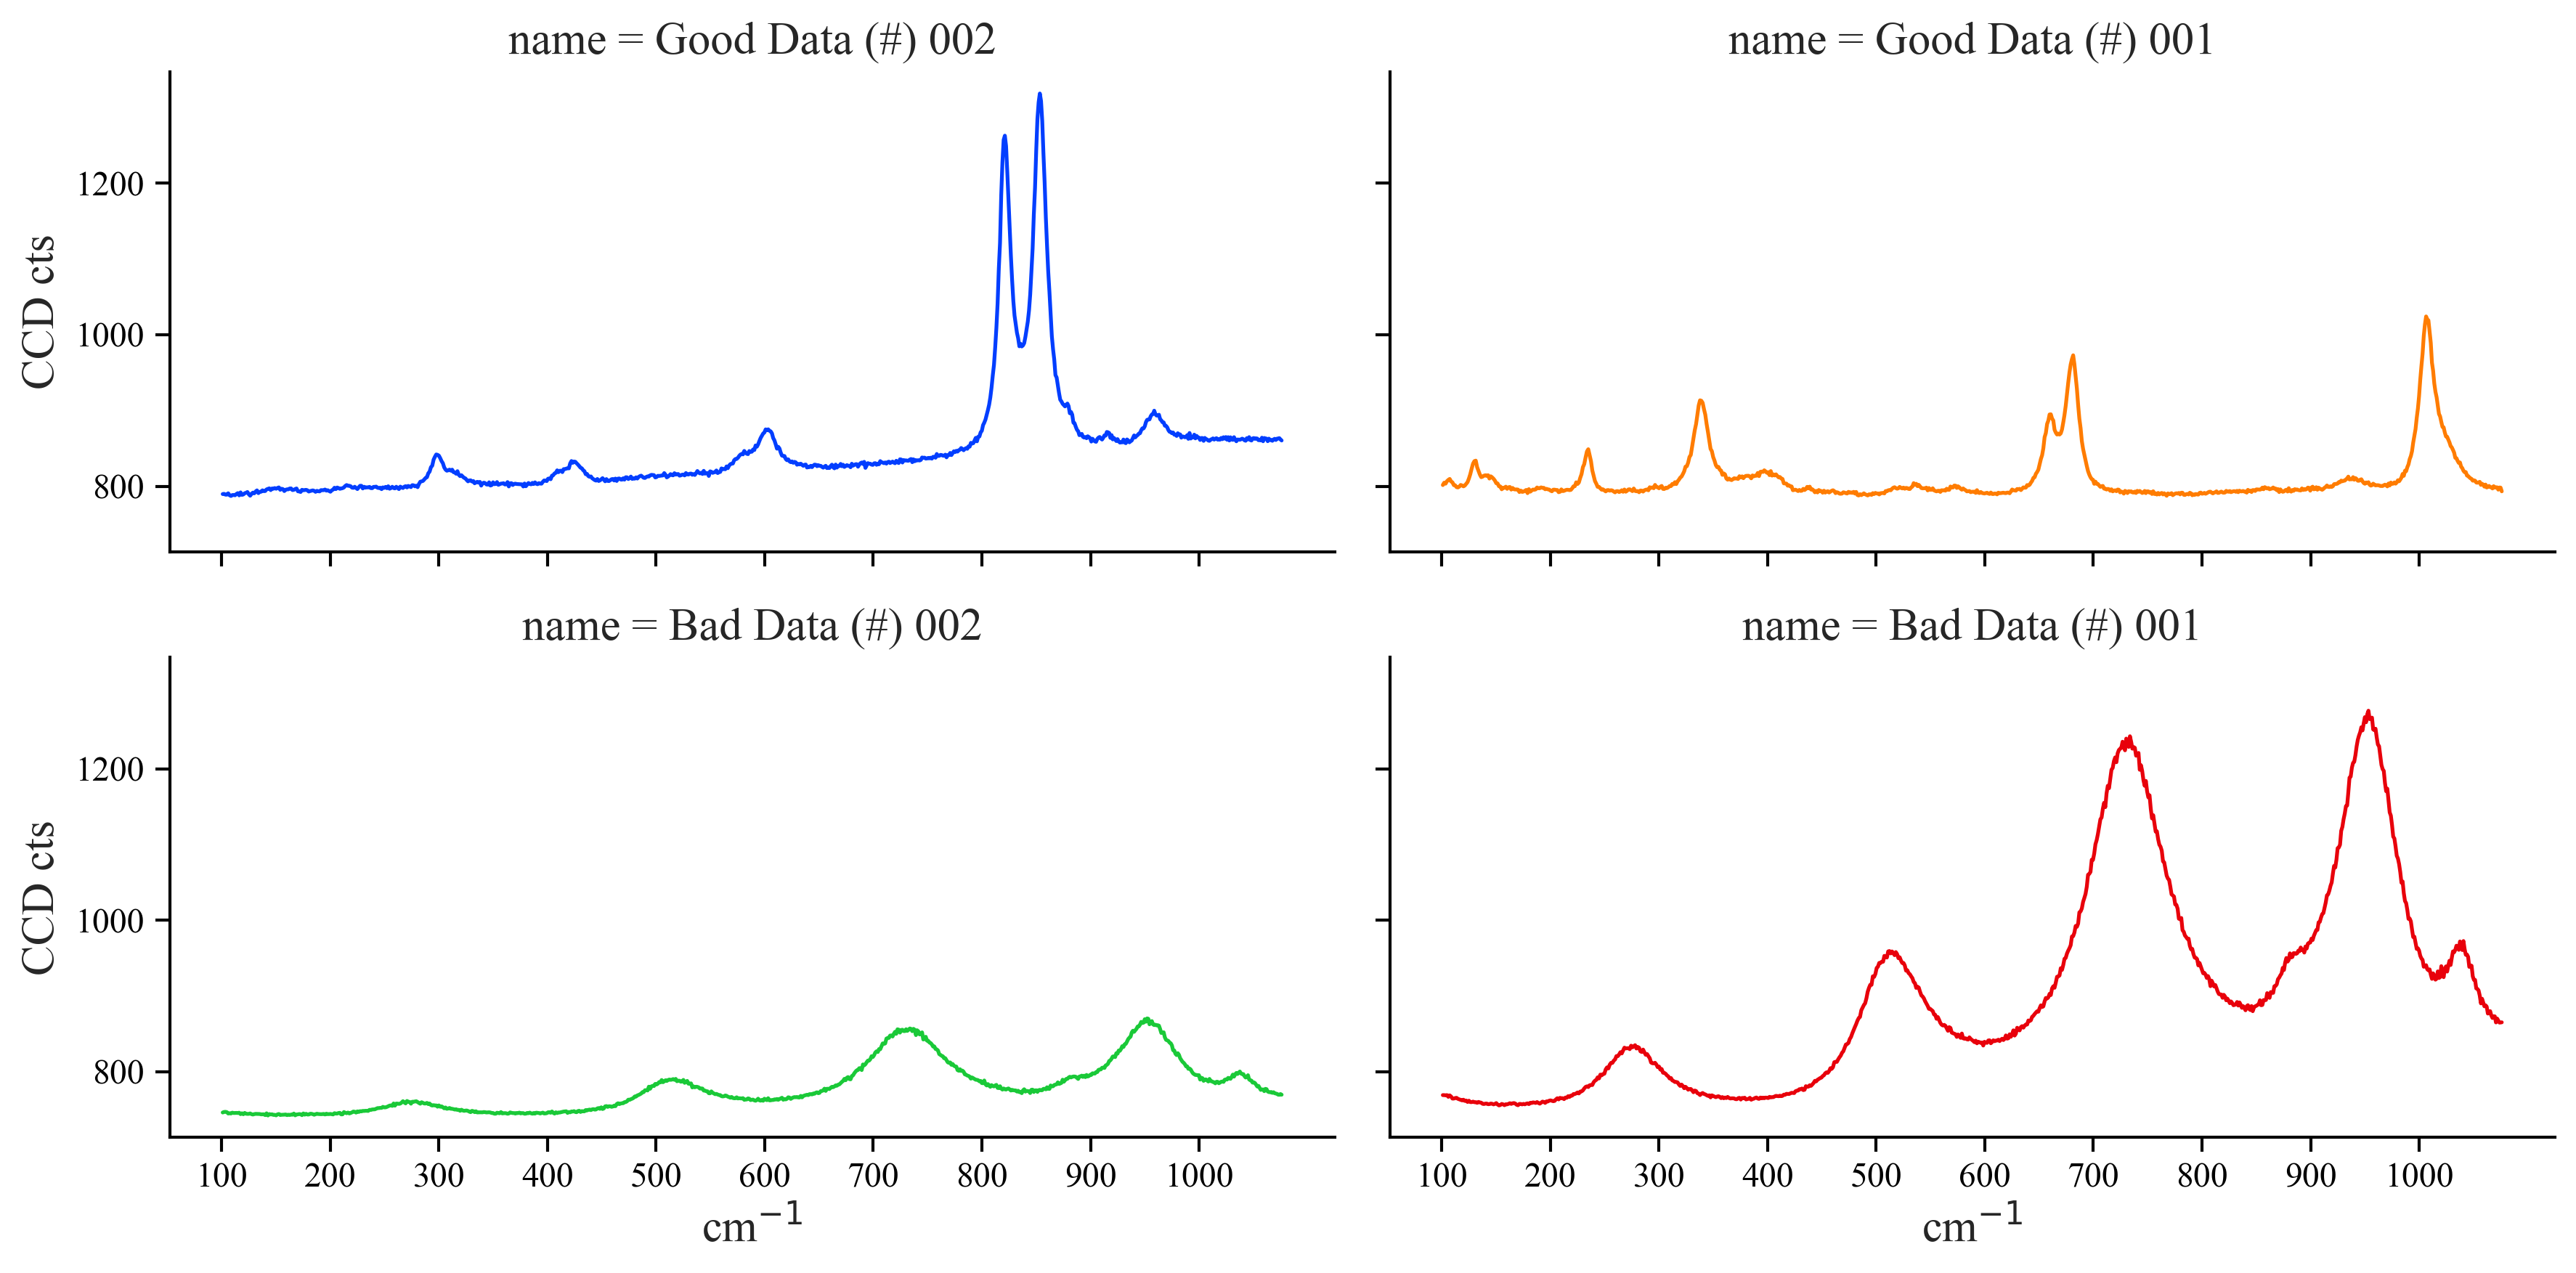

In [22]:
g = sns.relplot(data=data, x= 'x', y='y raw', 
            hue = 'name',col='name',kind = 'line',ci=None,col_wrap=2,
            height=3, aspect=2,linewidth=1.25,legend=False)

g.fig.get_axes()[0].set_xticks(np.linspace(100,1000,10))
(g.set_axis_labels("cm$^{-1}$", "CCD cts"))
plt.show()

## Deleting 'bad' data sets 

In [23]:
delete= ['Bad Data (#) 001','Bad Data (#) 002']
data.drop(data[data['name'].isin(delete)].index.tolist(),inplace=True)
data.dropna(inplace=True)

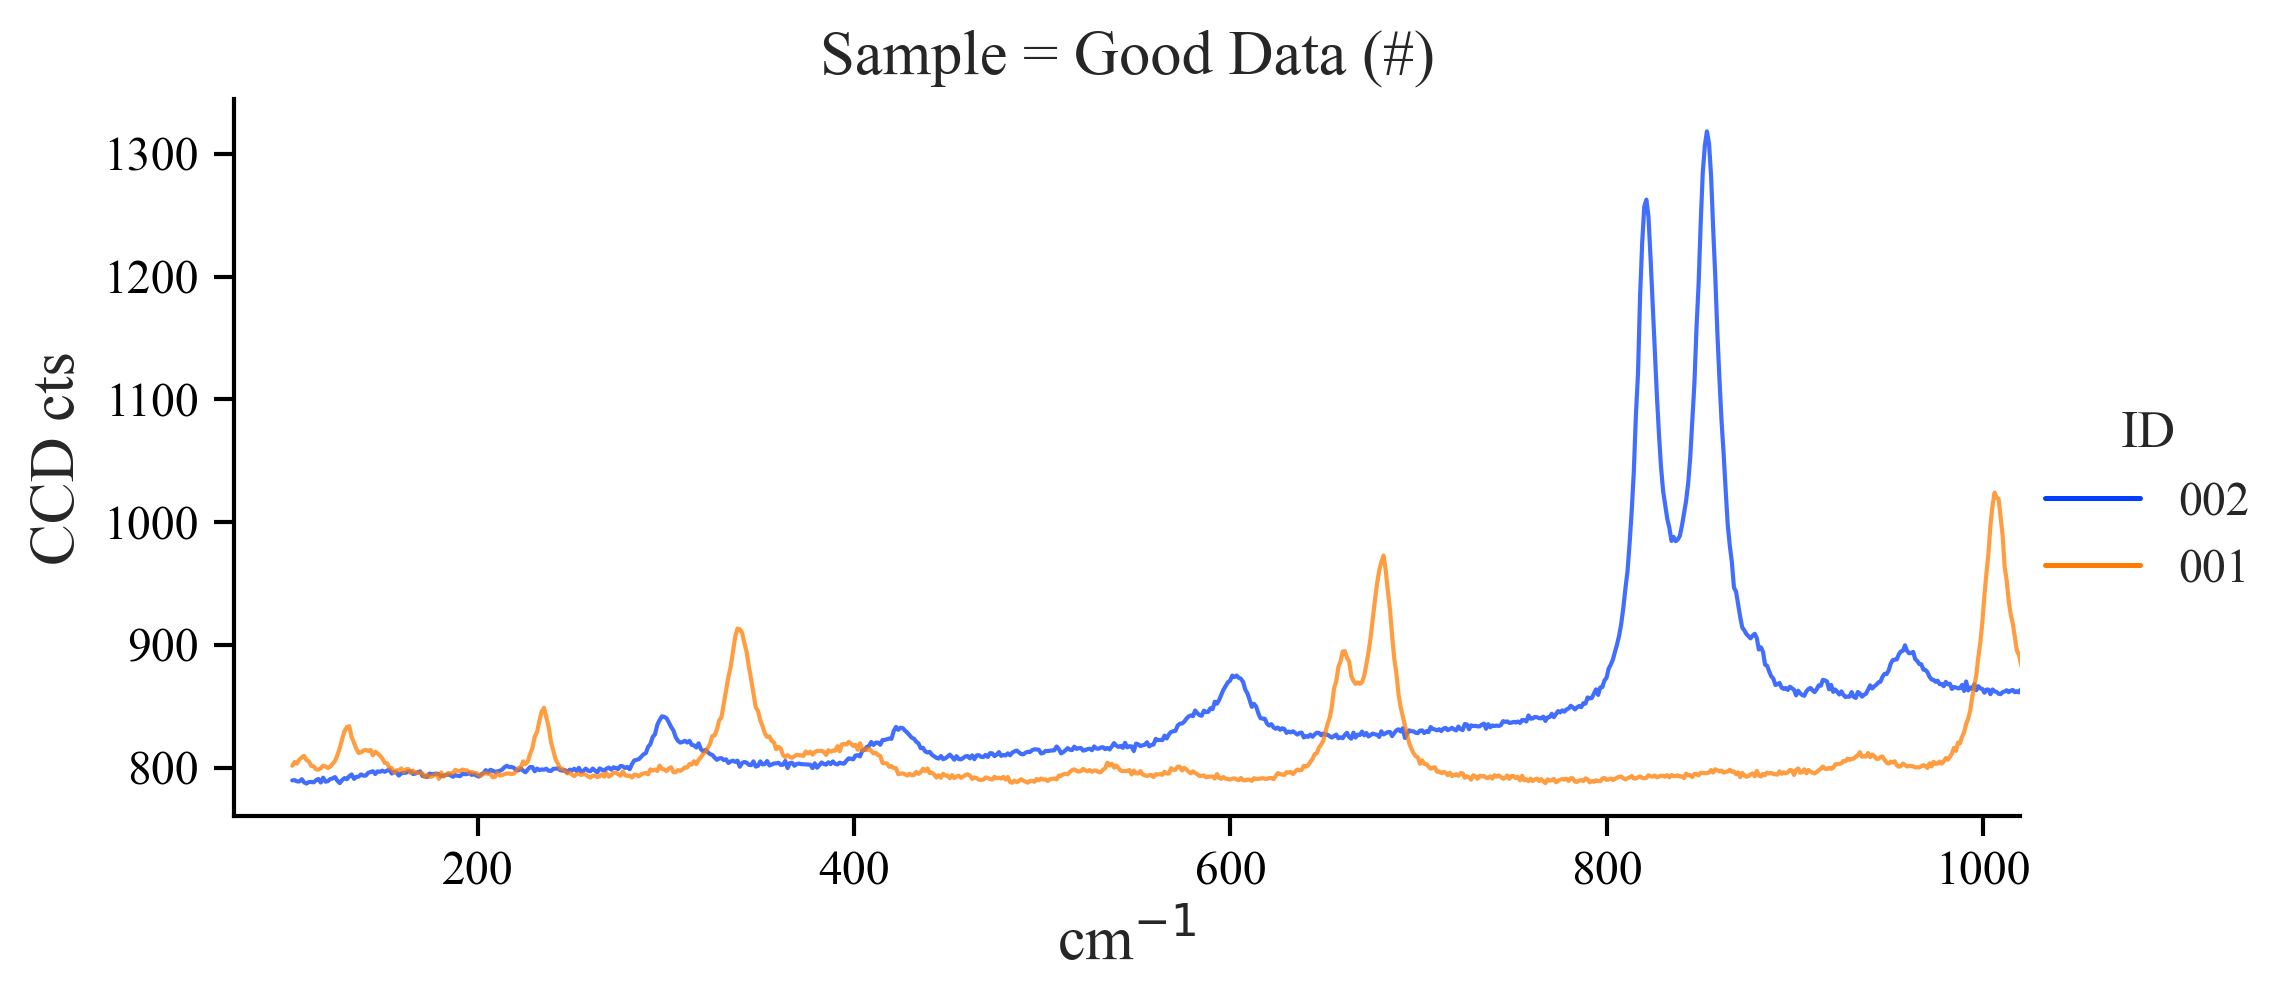

In [27]:
for sample in data['Sample #'].unique().tolist():
    g = sns.relplot(data=data[data['Sample #']==sample], x= 'x', y='y raw', 
                hue = 'ID',row='Sample',kind = 'line',ci=None,
                height=3.5, aspect=2,alpha=0.75,estimator = sum,linewidth=1, 
                dashes=False)
    (g.set_axis_labels("cm$^{-1}$", "CCD cts"))
    g.fig.get_axes()[0].set_xlim(70, 1020)
    plt.show()

# Comparing fitted data: Poly fit background subtraction (Zhao 2007)$^1$, adaptive least squares (Zhang 2010)$^2$, and raw data

$^1$ Automated Autofluorescence Background Subtraction Algorithm for Biomedical Raman Spectroscopy by Zhao, Jianhua, Lui, Harvey, McLean, David I., Zeng, Haishan (2007)

$^2$ Baseline correction using adaptive iteratively reweighted penalized least squares by Zhi-Min Zhang, Shan Chena and Yi-Zeng Liang (2010)

Methods avaliable in BaselineRemoval python library: https://pypi.org/project/BaselineRemoval/

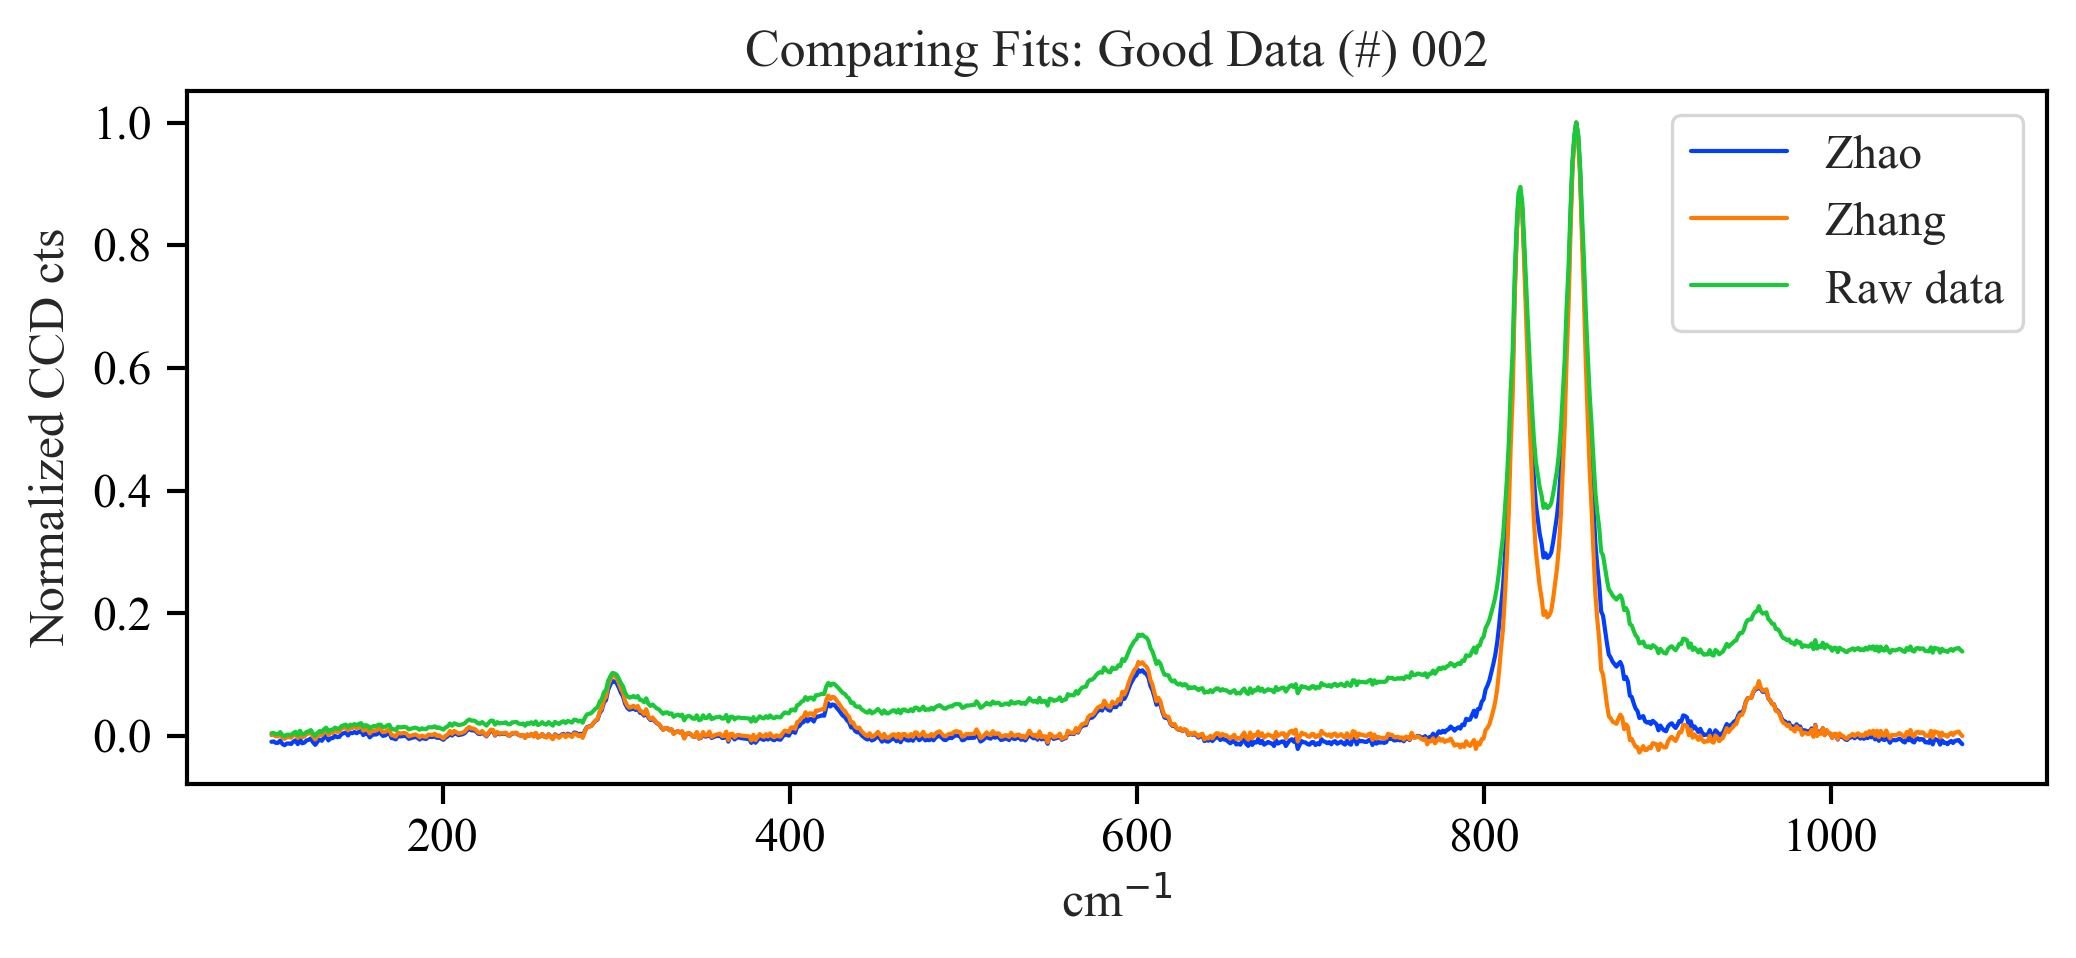

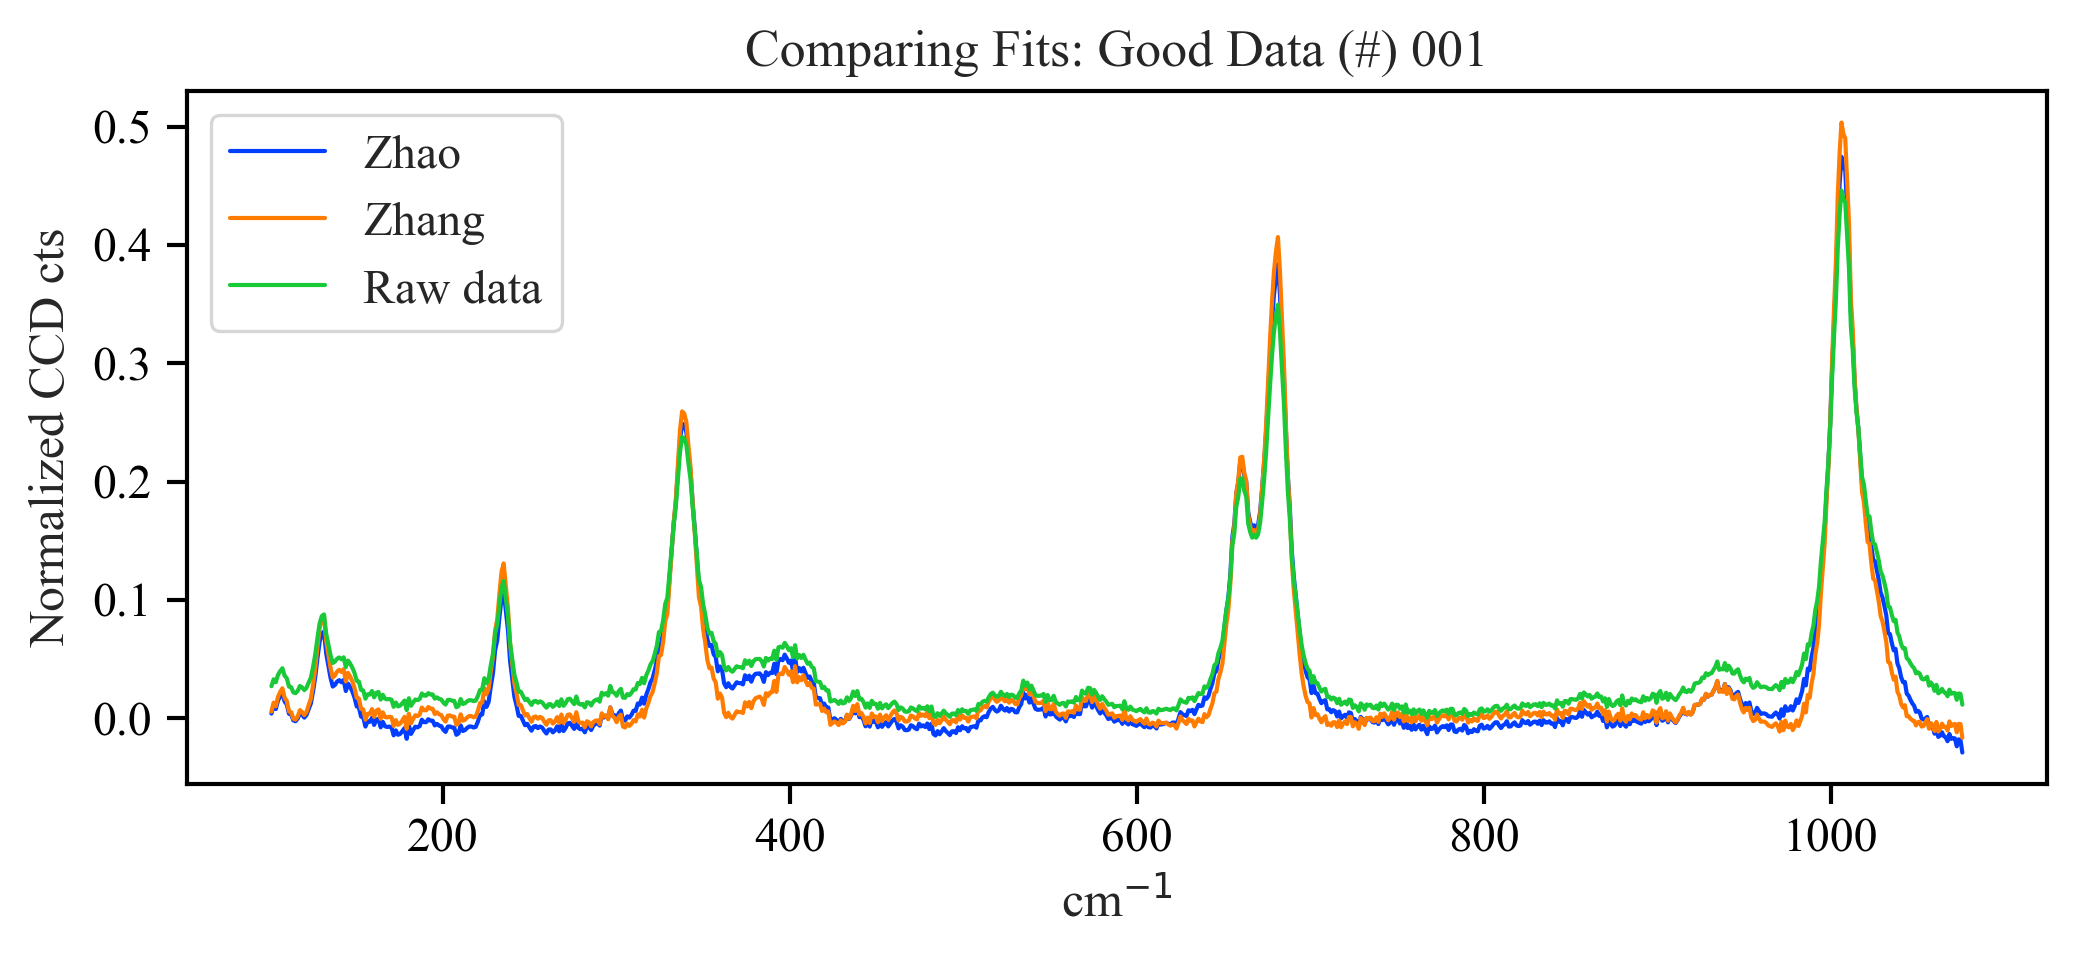

In [31]:
dt=data.copy()
#normalizing raw data
dt['y raw']=dt['y raw']-dt['y raw'].min() #re scaling for better comparison to fitted data
dt['y raw'] = dt['y raw']/dt['y raw'].max()

#normalizing raw data
dt['y Zhao'] =dt['y Zhao']/dt['y Zhao'].max()

#normalizing raw data
dt['y Zhang'] =dt['y Zhang']/dt['y Zhang'].max()

for sample in dt['name'].unique().tolist():
    plt.figure(figsize=(8,3))
    sns.lineplot(data=dt[dt['name']==sample], x= 'x', y='y Zhao', label='Zhao',
                linewidth=1)
    sns.lineplot(data=dt[dt['name']==sample], x= 'x', y='y Zhang', label='Zhang',
                linewidth=1)
    sns.lineplot(data=dt[dt['name']==sample], x= 'x', y='y raw', label='Raw data',
                linewidth=1)
    plt.xlabel('cm$^{-1}$',size=12)
    plt.ylabel('Normalized CCD cts',size=12)
    plt.title(f"Comparing Fits: {sample}")
    plt.show()

# Averaging and summing all data sets

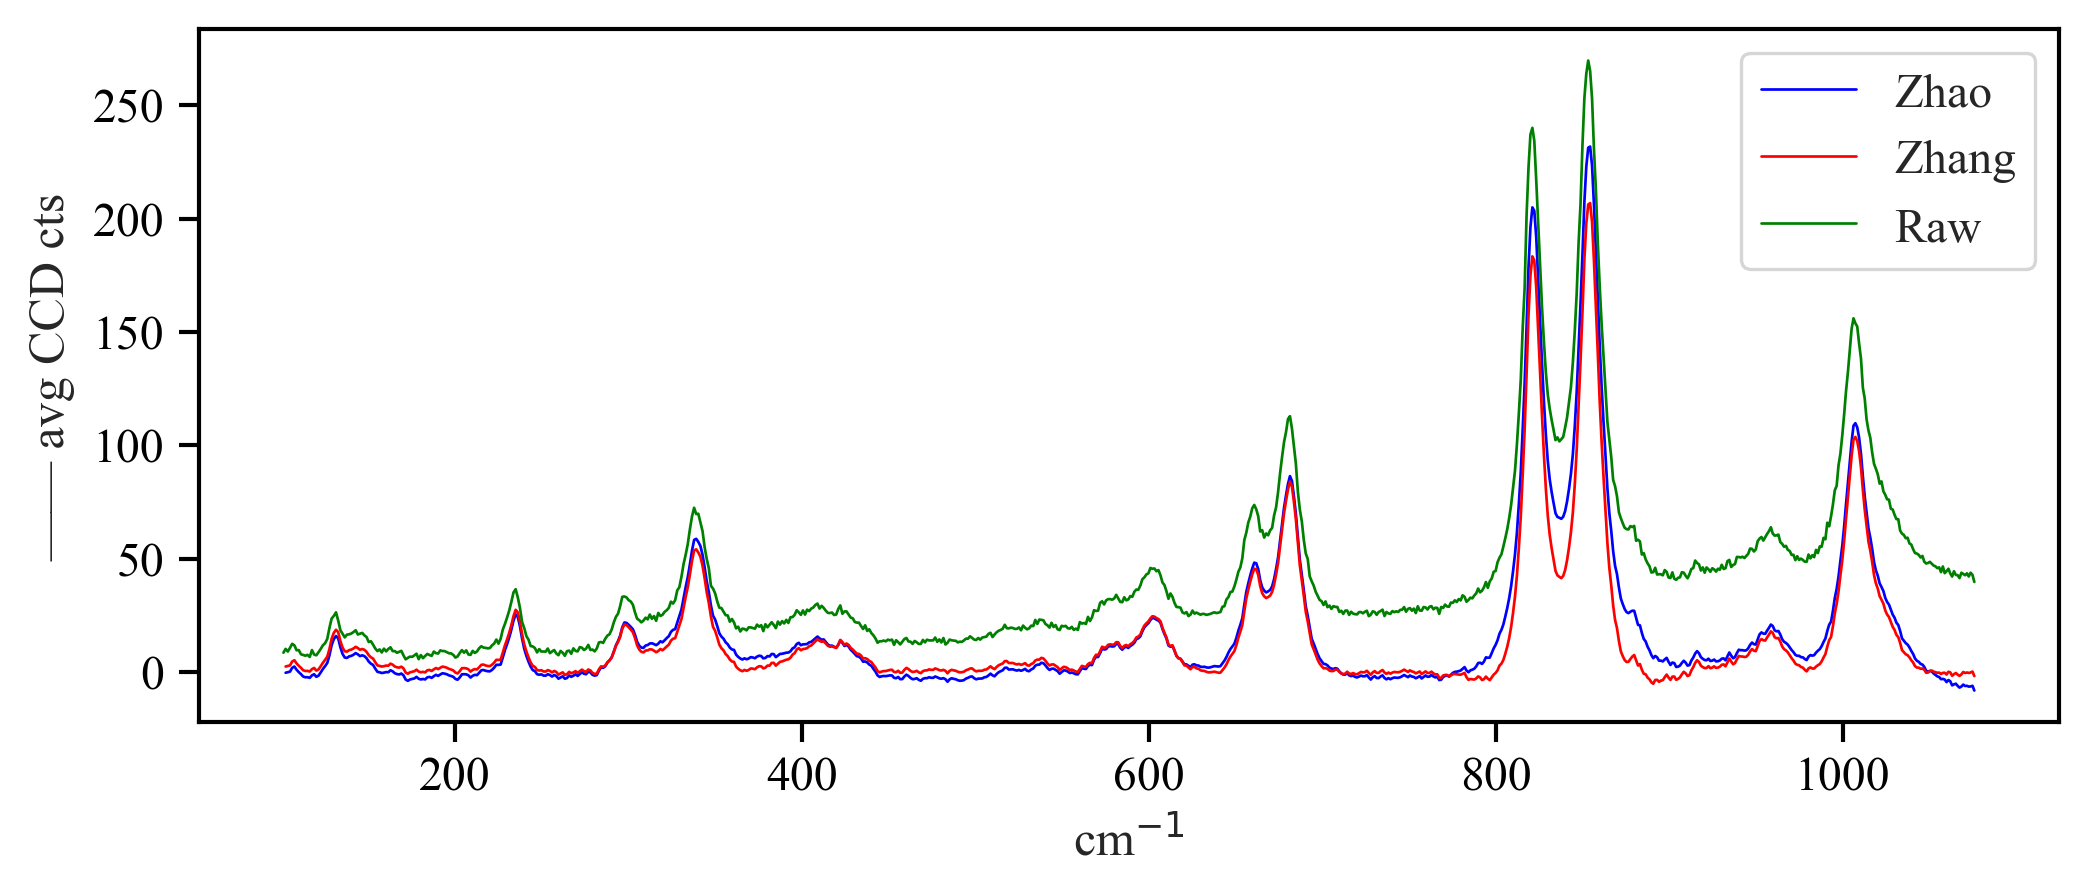

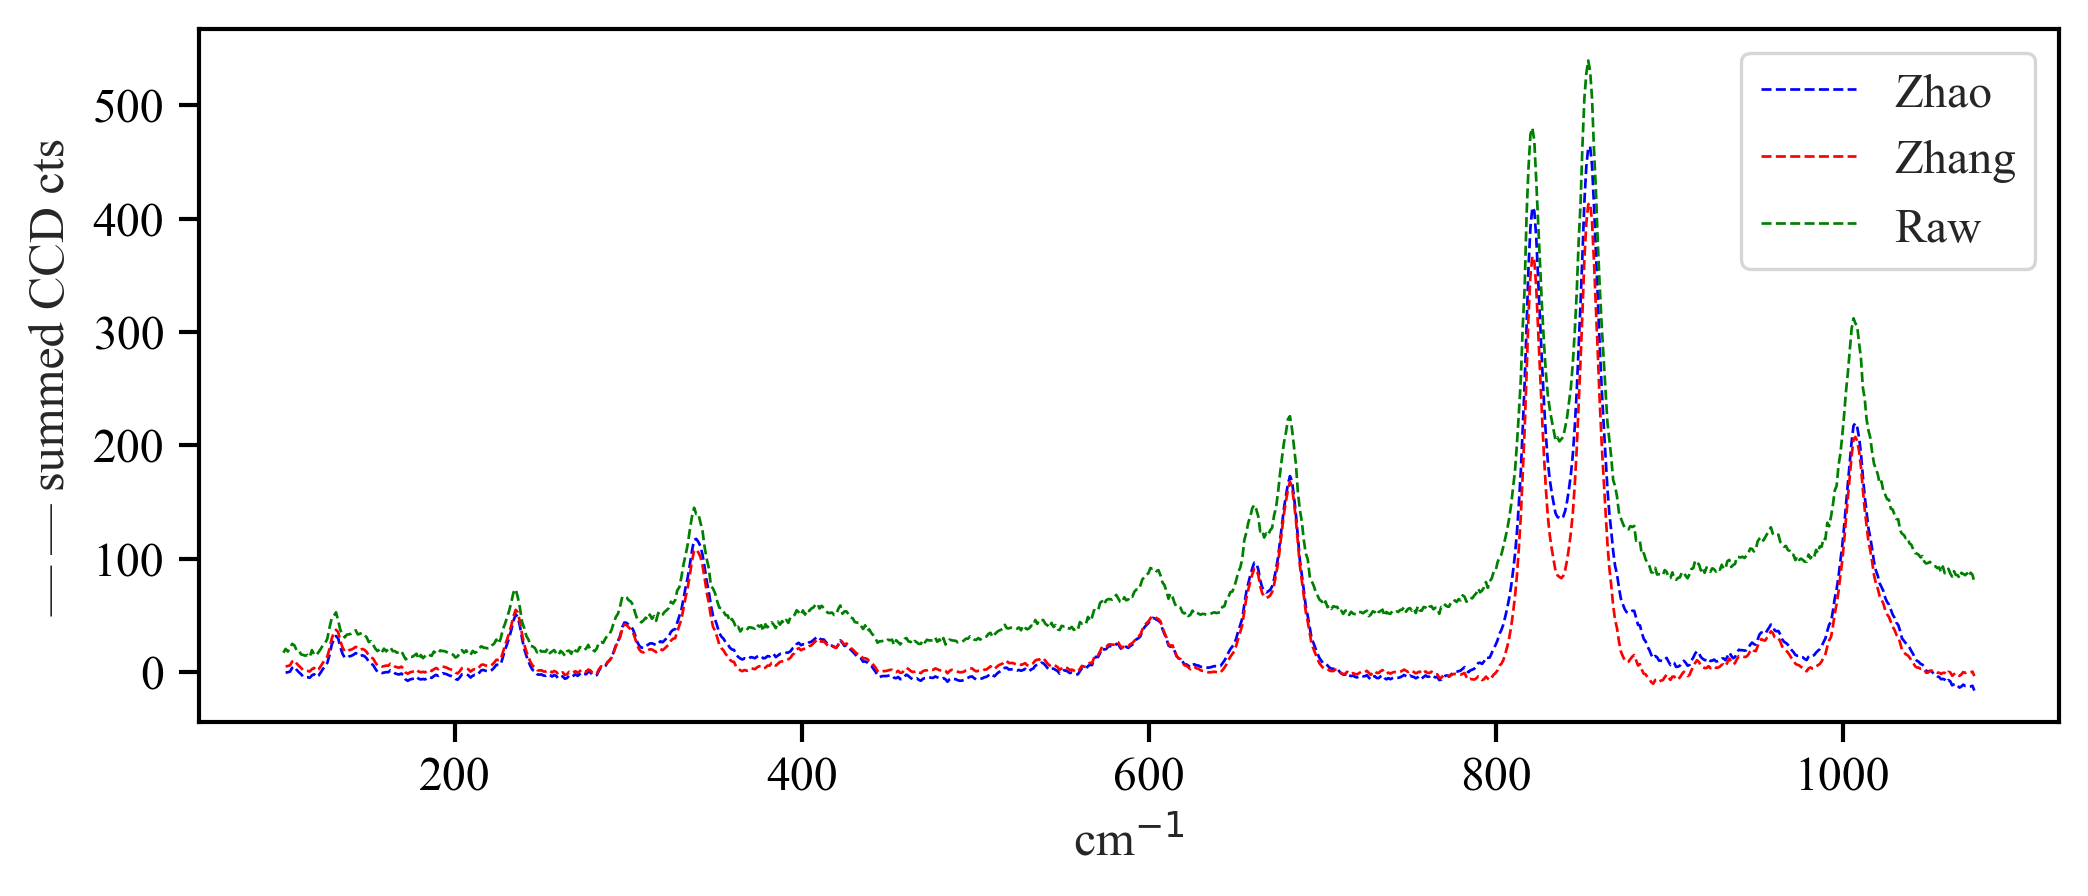

In [39]:
nrol=2

dt=data.copy()
dt['y sum'] = dt['y raw']-dt['y raw'].min()
dt['y avg'] = dt['y raw']-dt['y raw'].min()
dt = dt.groupby(['Simulant','x'],as_index=False).agg({'y sum': np.nansum, 
                 'y avg': lambda x: x.mean(skipna=True)})
dt.dropna(inplace=True)

dt_Zhao=data.copy()
dt_Zhao['y sum'] = dt_Zhao['y Zhao']
dt_Zhao['y avg'] = dt_Zhao['y Zhao']
dt_Zhao = dt_Zhao.groupby(['Simulant','x'],as_index=False).agg({'y sum': np.nansum, 
                 'y avg': lambda x: x.mean(skipna=True)})
dt_Zhao.dropna(inplace=True)
dt_Zhao['y sum'] = (dt_Zhao['y sum'].rolling(nrol,win_type ='triang').mean())
dt_Zhao['y avg'] = (dt_Zhao['y avg'].rolling(nrol,win_type ='triang').mean())

dt_Zhang=data.copy()
dt_Zhang['y sum'] = dt_Zhang['y Zhang']
dt_Zhang['y avg'] = dt_Zhang['y Zhang']
dt_Zhang = dt_Zhang.groupby(['Simulant','x'],as_index=False).agg({'y sum': np.nansum, 
                 'y avg': lambda x: x.mean(skipna=True)})
dt_Zhang.dropna(inplace=True)
dt_Zhang['y sum'] = (dt_Zhang['y sum'].rolling(nrol,win_type ='triang').mean())
dt_Zhang['y avg'] = (dt_Zhang['y avg'].rolling(nrol,win_type ='triang').mean())

plt.figure(figsize=(8,3))
sns.lineplot(data=dt_Zhao, x= 'x', y='y avg',color='blue',linestyle='-',label='Zhao',linewidth=0.65)
sns.lineplot(data=dt_Zhang, x= 'x', y='y avg',color='red',linestyle='-',label='Zhang',linewidth=0.65)
sns.lineplot(data=dt, x= 'x', y='y avg',color='green',linestyle='-',label='Raw',linewidth=0.65)
plt.xlabel('cm$^{-1}$',size=12)
plt.ylabel('—— avg CCD cts',size=12)
plt.show()

plt.figure(figsize=(8,3))
sns.lineplot(data=dt_Zhao, x= 'x', y='y sum',color='blue',linestyle='--',label='Zhao',linewidth=0.65)
sns.lineplot(data=dt_Zhang, x= 'x', y='y sum',color='red',linestyle='--',label='Zhang',linewidth=0.65)
sns.lineplot(data=dt, x= 'x', y='y sum',color='green',linestyle='--',label='Raw',linewidth=0.65)
plt.xlabel('cm$^{-1}$',size=12)
plt.ylabel('— — summed CCD cts',size=12)
plt.show()

# Final plots

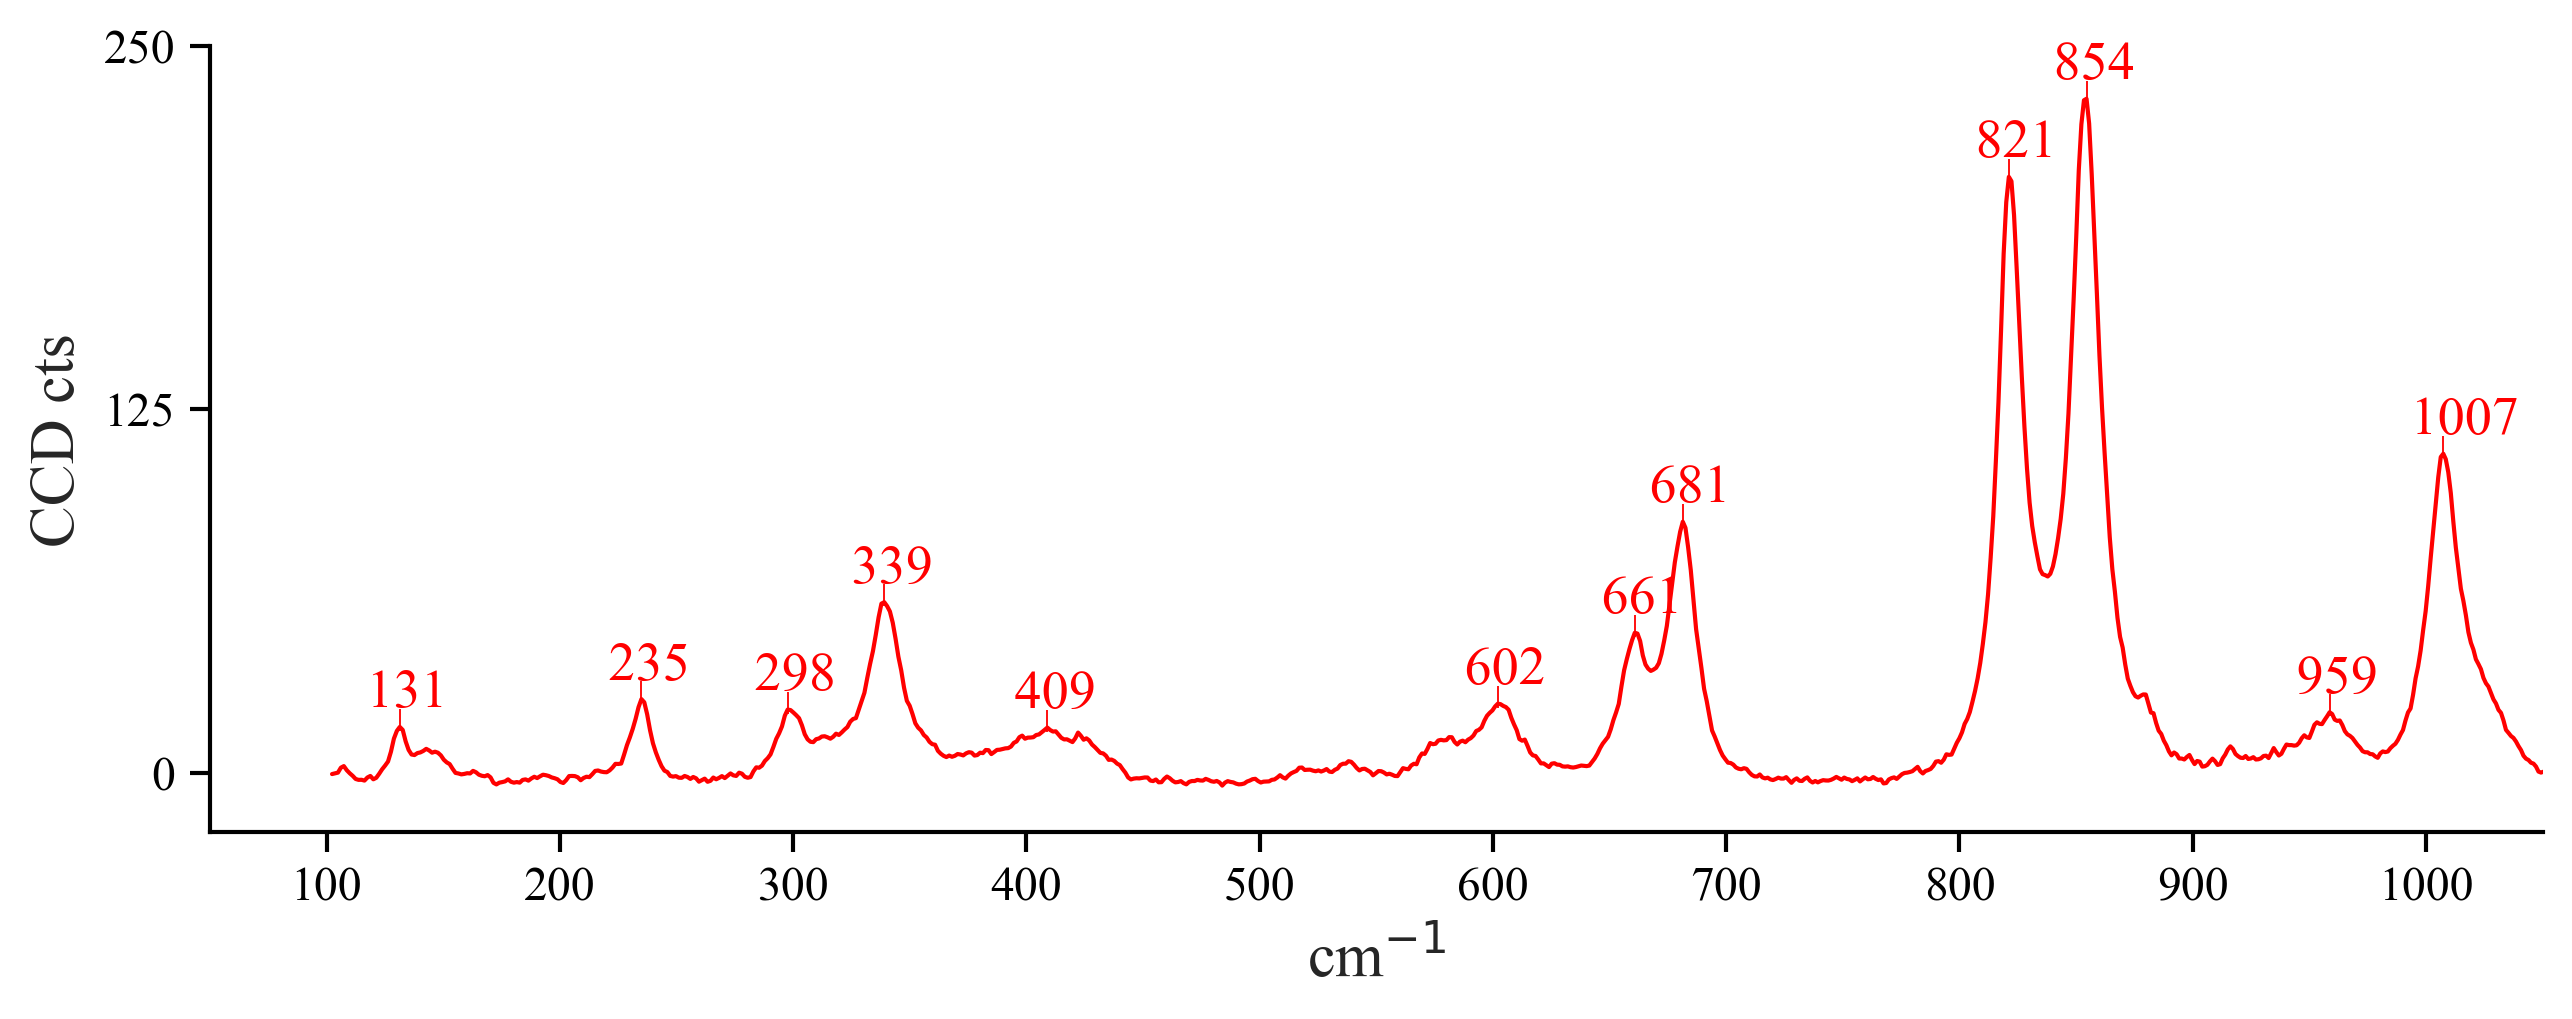

In [75]:
dt=dt_Zhao.copy()
g = sns.relplot(data=dt, x= 'x', y='y avg',kind = 'line',height=3.5, aspect=2.5,
                ci=None, alpha=1,linewidth=1,color='red')

dt['p'] = False
dt['p'].iloc[find_peaks(dt['y avg'],prominence=10)[0]] = True
peak_dt=dt[dt['p']==True]
peak_dt['y'] = peak_dt['y avg']+dt['y avg'].max()/100
ax=g.fig.get_axes()[0]
sns.scatterplot(data=peak_dt, x= 'x', y='y',ax=ax,color='red',marker='|',s=30)
peaks=peak_dt['y'].tolist()

i=0
for x in peak_dt['x'].tolist():
    ax.annotate(f'{x: .0f}', (x-20,peaks[i]+dt['y avg'].max()/50),rotation=0,fontsize=13,color='red')
    i+=1
    
(g.set_axis_labels("cm$^{-1}$", "CCD cts"))
g.fig.get_axes()[0].set_xlim(50, 1050)
g.fig.get_axes()[0].set_xticks(np.linspace(100,1000,10))
mx = int(str(int(dt['y avg'].max()*1.1))[:-1]+'0')
n = int(mx/100) + 1
g.fig.get_axes()[0].set_yticks(np.linspace(0,mx,n))

plt.show()
#g.savefig('Test_avg_plot_peaks.png')